In [31]:
import pandas as pd
from datetime import timedelta
PRED_LEN  = 24  
HIST_LEN  = 48  # 2 days of history
CSV_PATH = "consumption.csv"
GROUP_ID  = "electricity"          # whatever you called it earlier

df_raw = pd.read_csv(CSV_PATH, header=None, names=["timestamp", "WattHour"])
df_raw["timestamp"] = pd.to_datetime(df_raw["timestamp"])

# shift 5 min → floor → +1 h  ➜ “hour bucket”
df_raw["hour_bucket"] = (df_raw["timestamp"] - pd.Timedelta(minutes=5)
                        ).dt.floor("H") + pd.Timedelta(hours=1)
df_raw["day"]  = df_raw["hour_bucket"].dt.floor("D")           # e.g. 2025-05-26T00:00:00Z
df_raw["hour"] = df_raw["hour_bucket"].dt.hour                 # 0‥23

past = (df_raw
          .groupby(["day", "hour"], as_index=False)
          .agg(
              WattHour = ("WattHour", "sum"),
              orig_ts  = ("timestamp", "min")   # earliest raw ts in that slot
          ))

past["Timestamp"] = (
    past["day"]                         # midnight anchor
    + pd.to_timedelta(past["hour"], unit="h")  # + hour offset
)
past = past.iloc[-HIST_LEN:].reset_index(drop=True)  # keep last 48 hours
# ---------- 2. ADD 24 FUTURE HOURS ----------
last_ts   = past["Timestamp"].iloc[-1]
last_idx  = len(past) - 1

future = pd.DataFrame({
    "Timestamp"   : pd.date_range(last_ts + timedelta(hours=1),
                                  periods=PRED_LEN, freq="H", tz="UTC"),
    "WattHour" :0,
    "orig_ts"     : pd.NaT
})


/tmp/ipykernel_828999/1882659344.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ).dt.floor("H") + pd.Timedelta(hours=1)
/tmp/ipykernel_828999/1882659344.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "Timestamp"   : pd.date_range(last_ts + timedelta(hours=1),


In [32]:
from data_preparation import pepare_data, preparation_data_darts, FEAT_ORDER
import numpy as np
df_past = pepare_data(past)
df_future = pepare_data(future)
NEW_FEAT_ORDER = ["WattHour", *FEAT_ORDER,*FEAT_ORDER]
past_block = (
    df_past.loc[:, NEW_FEAT_ORDER]             # keep columns in the declared order
                         # pick the last 48 time-steps
      .to_numpy(dtype=np.float32)     # → ndarray  shape (48, 6)
)

future_block = (
    df_future.loc[:, FEAT_ORDER]             # keep columns in the declared order
                         # pick the last 48 time-steps
      .to_numpy(dtype=np.float32)     # → ndarray  shape (48, 6)
)

past_block   = np.expand_dims(past_block,   axis=0).astype(np.float32)
future_block = np.expand_dims(future_block, axis=0).astype(np.float32)



In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort
from pathlib import Path
from datetime import timedelta

onnx_path  = Path("tide_edge.onnx")           # exported TiDE model
input_len  = 48                               # encoder length
horizon    = 24                               # decoder length
# ----------------------------





In [34]:
print(df_raw.shape)

(586, 5)


In [35]:
ort_inputs = {
    "x_past":   past_block,      # shape (1, 48, n_feat)
    "x_future": future_block,    # shape (1, 24, n_feat)
}


# 3) Run ONNX inference
sess = ort.InferenceSession(str(onnx_path), providers=["CPUExecutionProvider"])


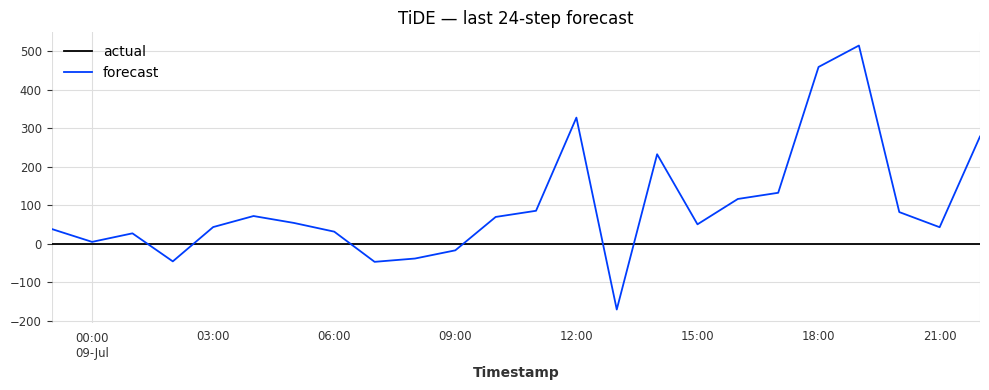

In [36]:
forecast, = sess.run(None, ort_inputs)  # (1, horizon, 1)
forecast = forecast.squeeze()   # shape (horizon,)

# 4) Build a dataframe for plotting
ts_index = future["Timestamp"].iloc[-horizon:]
plot_df = pd.DataFrame({
    "truth": future["WattHour"].iloc[-horizon:].values,
    "pred" : forecast
}, index=ts_index)

# 5) Plot
plt.figure(figsize=(10, 4))
plot_df["truth"].plot(label="actual")
plot_df["pred"].plot(label="forecast")
plt.title("TiDE — last 24-step forecast")
plt.legend()
plt.tight_layout()
plt.show()